# COVID-19 HOSPITALIZATION CLASSIFICATION MODEL

### Melissa Mullen - COMP 740 Individual Implementation Project

In [1]:
import numpy as np 
import pandas as pd 

df = pd.read_csv('clean_covid.csv')

In [78]:
# for saving the training history plots

PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,sex,patient_type,intubed,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
0,0,1,NaN,0,27,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN
1,1,1,NaN,0,56,0,0,0,0,0,1,0,0,0,1,1,1,1,NaN
2,1,1,NaN,0,34,0,0,0,0,0,0,0,0,0,0,0,1,1,NaN
3,1,1,NaN,0,34,0,0,0,0,0,0,0,0,0,0,1,0,1,NaN
4,1,1,NaN,0,49,0,1,0,0,0,0,0,0,0,0,0,1,1,NaN


## Initial Data Exploration and Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342604 entries, 0 to 342603
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   sex                  342604 non-null  int64  
 1   patient_type         342604 non-null  int64  
 2   intubed              51679 non-null   float64
 3   pneumonia            342604 non-null  int64  
 4   age                  342604 non-null  int64  
 5   pregnancy            342604 non-null  int64  
 6   diabetes             342604 non-null  int64  
 7   copd                 342604 non-null  int64  
 8   asthma               342604 non-null  int64  
 9   inmsupr              342604 non-null  int64  
 10  hypertension         342604 non-null  int64  
 11  other_disease        342604 non-null  int64  
 12  cardiovascular       342604 non-null  int64  
 13  obesity              342604 non-null  int64  
 14  renal_chronic        342604 non-null  int64  
 15  tobacco          

In [4]:
df.isnull().sum()

sex                         0
patient_type                0
intubed                290925
pneumonia                   0
age                         0
pregnancy                   0
diabetes                    0
copd                        0
asthma                      0
inmsupr                     0
hypertension                0
other_disease               0
cardiovascular              0
obesity                     0
renal_chronic               0
tobacco                     0
contact_other_covid         0
covid_res                   0
icu                    290925
dtype: int64

These missing values aren't problematic. I will be dropping these two columns before building the model since I'm predicting whether somebody will be hospitalized and these two columns contain data about after hospitalization.

In [5]:
df.describe()

,sex,patient_type,intubed,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
count,342604.000000,342604.000000,51679.000000,342604.000000,342604.000000,342604.000000,342604.000000,342604.000000,342604.000000,342604.000000,342604.000000,342604.000000,342604.000000,342604.000000,342604.000000,342604.000000,342604.000000,342604.000000,51679.000000
mean,0.491454,0.849158,0.135452,0.128344,41.433378,0.006988,0.107167,0.012685,0.030245,0.012913,0.138988,0.016030,0.019901,0.158550,0.014139,0.087425,0.569453,0.402660,0.130111
std,0.499928,0.357895,0.342209,0.334472,16.379029,0.083300,0.309326,0.111912,0.171261,0.112899,0.345935,0.125592,0.139659,0.365257,0.118063,0.282457,0.495153,0.490434,0.336429
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,52.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,120.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df.covid_res.value_counts()

0    204651
1    137953
Name: covid_res, dtype: int64

Where we are concerned about whether somebody diagnosed with COVID-19 was hospitalized, we don't need the data with negative test results.

In [7]:
df = df.loc[(df.covid_res == 0)]
df.covid_res.value_counts()

0    204651
Name: covid_res, dtype: int64

In [8]:
df.shape

(204651, 19)

In [9]:
df.corr()

,sex,patient_type,intubed,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
sex,1.000000,0.047763,-0.035819,-0.048813,-0.003838,0.083119,-0.011649,-0.005540,0.036648,0.006565,-0.004608,0.014687,-0.010306,0.020629,-0.012052,-0.109004,0.035612,NaN,-0.022184
patient_type,0.047763,1.000000,NaN,-0.658165,-0.135222,-0.027894,-0.193157,-0.133270,0.005741,-0.122657,-0.154083,-0.115577,-0.109319,-0.026901,-0.144655,-0.007157,0.217269,NaN,NaN
intubed,-0.035819,NaN,1.000000,0.183757,-0.011285,-0.033947,0.027887,0.004582,-0.019045,0.013184,0.021657,0.037558,0.033967,0.030952,0.027725,0.012232,-0.043186,NaN,0.426373
pneumonia,-0.048813,-0.658165,0.183757,1.000000,0.153433,-0.002254,0.176761,0.122024,-0.003796,0.092399,0.142059,0.085279,0.096465,0.038863,0.127198,0.009912,-0.168386,NaN,0.125373
age,-0.003838,-0.135222,-0.011285,0.153433,1.000000,-0.059379,0.299282,0.160904,-0.020797,0.025080,0.358199,0.025975,0.127494,0.096113,0.089976,0.024431,-0.055966,NaN,-0.046148
pregnancy,0.083119,-0.027894,-0.033947,-0.002254,-0.059379,1.000000,-0.019802,-0.005718,0.000945,-0.000590,-0.023653,0.021965,-0.007696,-0.013997,-0.006799,-0.018269,-0.040897,NaN,-0.017115
diabetes,-0.011649,-0.193157,0.027887,0.176761,0.299282,-0.019802,1.000000,0.105580,0.005415,0.052484,0.349759,0.038697,0.116698,0.115261,0.155987,0.019174,-0.081780,NaN,0.009097
copd,-0.005540,-0.133270,0.004582,0.122024,0.160904,-0.005718,0.105580,1.000000,0.037665,0.052070,0.122120,0.050211,0.120986,0.038673,0.077183,0.063228,-0.059035,NaN,-0.004033
asthma,0.036648,0.005741,-0.019045,-0.003796,-0.020797,0.000945,0.005415,0.037665,1.000000,0.024259,0.019294,0.016011,0.020607,0.046697,0.004616,0.010421,0.002352,NaN,-0.019329
inmsupr,0.006565,-0.122657,0.013184,0.092399,0.025080,-0.000590,0.052484,0.052070,0.024259,1.000000,0.044794,0.154920,0.066499,0.016491,0.102031,0.006184,-0.050216,NaN,0.028536


In [10]:
corr_matrix = df.corr()

corr_matrix['patient_type'].sort_values(ascending=False)

patient_type           1.000000
contact_other_covid    0.217269
sex                    0.047763
asthma                 0.005741
tobacco               -0.007157
obesity               -0.026901
pregnancy             -0.027894
cardiovascular        -0.109319
other_disease         -0.115577
inmsupr               -0.122657
copd                  -0.133270
age                   -0.135222
renal_chronic         -0.144655
hypertension          -0.154083
diabetes              -0.193157
pneumonia             -0.658165
intubed                     NaN
covid_res                   NaN
icu                         NaN
Name: patient_type, dtype: float64

Based on the correlation data above, contact_other_covid and pneumonia appear to be noticeably correlated with whether somebody will be hospitalized or not.

## Data Visualization

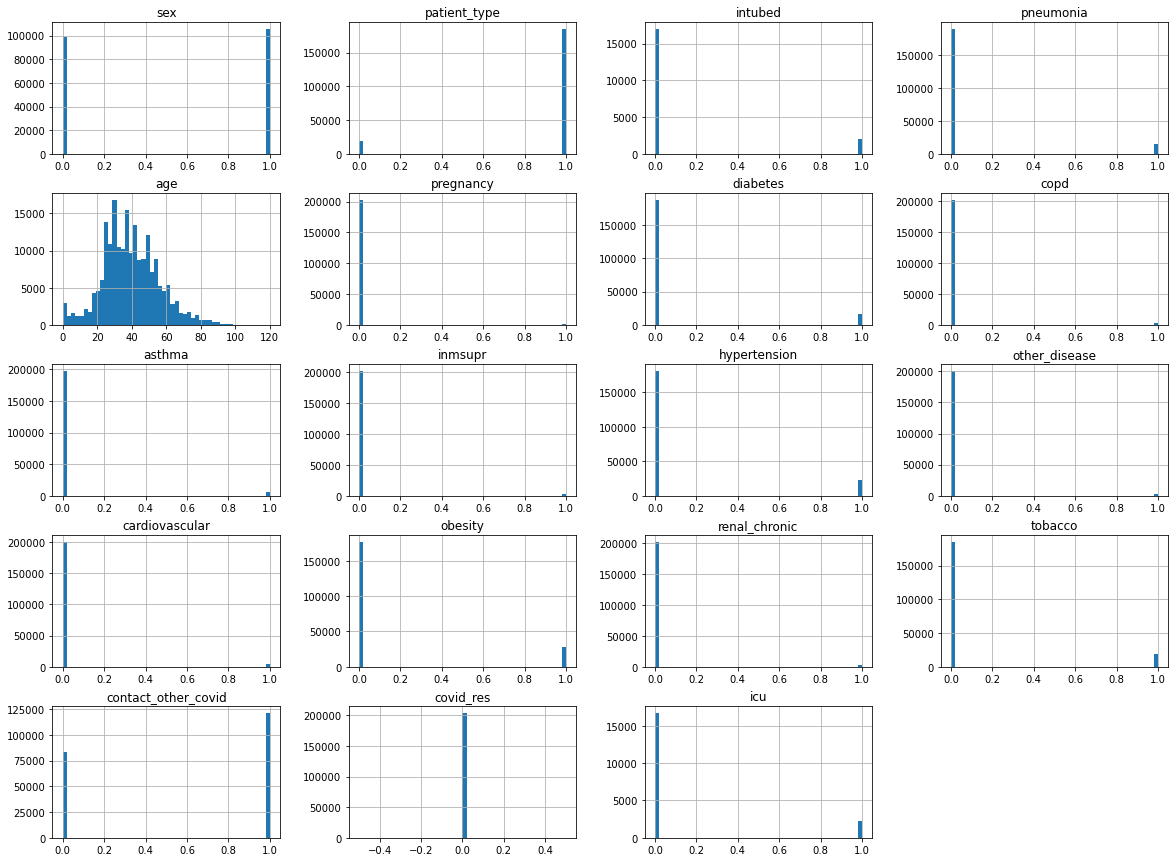

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

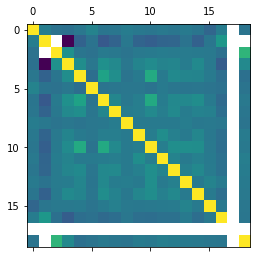

In [12]:
plt.matshow(df.corr())
plt.show()

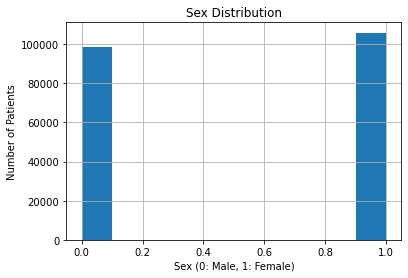

In [13]:
df.sex.hist()

plt.xlabel('Sex (0: Male, 1: Female)')
plt.ylabel('Number of Patients')
plt.title('Sex Distribution')
 
plt.show()

This dataset is more or less evenly balanced in regards to sex, which is nice.

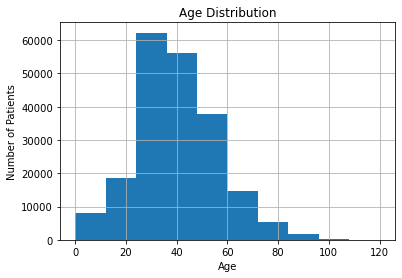

In [14]:
df.age.hist()

plt.xlabel('Age')
plt.ylabel('Number of Patients')
plt.title('Age Distribution')
 
plt.show()

I did this graph to make sure there wasn't any funky age values. I don't see any noticable issues, so I'm going to leave the age column as is.

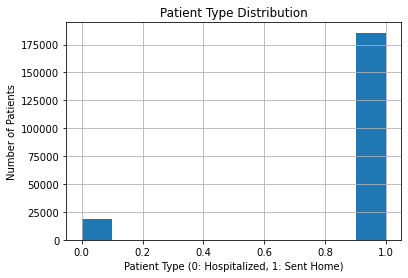

In [15]:
df.patient_type.hist()

plt.xlabel('Patient Type (0: Hospitalized, 1: Sent Home)')
plt.ylabel('Number of Patients')
plt.title('Patient Type Distribution')
 
plt.show()

This is the target column, I wish there were more patients hospitalized in this dataset since the data is so unbalanced, but it'll probably be fine.

## Data Preparation

Since we are trying to predict whether a patient is going to be hospitalized from COVID-19, we should delete columns containing information about once a patient is hospitalized.

In [16]:
df.drop(columns = ['icu', 'intubed'], inplace=True)
df.columns

Index(['sex', 'patient_type', 'pneumonia', 'age', 'pregnancy', 'diabetes',
       'copd', 'asthma', 'inmsupr', 'hypertension', 'other_disease',
       'cardiovascular', 'obesity', 'renal_chronic', 'tobacco',
       'contact_other_covid', 'covid_res'],
      dtype='object')

In [17]:
from sklearn.model_selection import train_test_split

np.random.seed(42)

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

train_labels = train_data['patient_type'].copy()
train_data = train_data.drop("patient_type", axis=1) 

test_labels = test_data['patient_type'].copy()
test_data = test_data.drop("patient_type", axis=1) 

In [18]:
test_data.head()

,sex,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res
255533,1,0,40,0,0,0,0,0,0,0,0,0,0,0,1,0
187367,1,0,28,0,0,0,0,0,0,0,0,0,0,0,1,0
168641,1,0,84,0,1,0,0,0,1,0,0,0,0,0,0,0
220182,0,0,38,0,0,0,0,0,0,0,0,0,0,0,0,0
289023,1,0,30,1,0,0,0,0,0,0,0,0,0,0,0,0


Without the icu and intubed columns there isn't any missing data, so I don't need to use SimpleImputer. Rather, I will use Principal Component Analysis (PCA) to reduce dimensionality. There are no columns that contain text or categorical data, so there is no need for OrdinalEncoder or OneHotEncoder. Similarly, due to the binary nature of the data, there is no need to use StandardScaler.

## Building the Pipelines

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

num_pipeline = Pipeline([
			('pca', PCA(n_components=2)),
])

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

lr_pipeline = Pipeline([
			('pca', PCA(n_components=2)),
            ('lr', LogisticRegression(random_state=42))
])

tree_pipeline = Pipeline([
			('pca', PCA(n_components=2)),
            ('lr', DecisionTreeClassifier(random_state=42))
])

rf_pipeline = Pipeline([
		('pca', PCA(n_components=2)),
		('clf', RandomForestClassifier(random_state=42))
])

In [46]:
pipelines = [lr_pipeline, tree_pipeline, rf_pipeline]
			
pipe_dict = {0: 'Logistic Regression', 1: 'Decistion Tree Classifier', 2: 'Random Forest Classifier'}

In [50]:
for pipe in pipelines:
	pipe.fit(train_data, train_labels)

for idx, val in enumerate(pipelines):
	print('%s pipeline test accuracy: %.3f' % (pipe_dict[idx], val.score(test_data, test_labels)))

Logistic Regression pipeline test accuracy: 0.906
Decistion Tree Classifier pipeline test accuracy: 0.938
Random Forest Classifier pipeline test accuracy: 0.945


It looks like the Random Forest Classifier performs better than the other two models, but I want to look at the precision and recall scores before choosing a model.

In [57]:
train_data_prepared = num_pipeline.fit_transform(train_data)
test_data_prepared = num_pipeline.fit_transform(test_data)

In [59]:
log_reg = LogisticRegression()
log_reg.fit(train_data_prepared, train_labels)

LogisticRegression()

In [60]:
final_pred = log_reg.predict(test_data_prepared)

from sklearn.metrics import precision_score, recall_score, accuracy_score

print("Precision score: ", (precision_score(test_labels, final_pred)))
print("Recall score: ", (recall_score(test_labels, final_pred)))
print("Accuracy score: ", (accuracy_score(test_labels, final_pred)))

Precision score:  0.9064607565242889
Recall score:  0.9999460887379373
Accuracy score:  0.9064278908406831


In [65]:
from sklearn.model_selection import validation_curve

param_range = np.arange(1, 100, 2)

train_scores, valid_scores = validation_curve(log_reg, train_data_prepared, train_labels, param_name="max_iter", param_range=param_range,cv=3, scoring="accuracy", n_jobs=-1)

In [66]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(valid_scores, axis=1)
test_std = np.std(valid_scores, axis=1)

Saving figure logistic_validation_curve


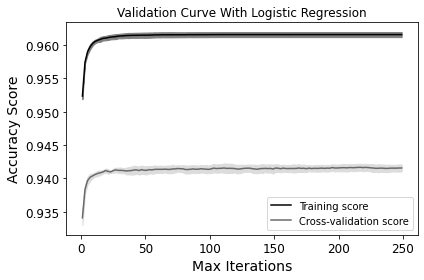

In [79]:
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Logistic Regression")
plt.xlabel("Max Iterations")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
save_fig("logistic_validation_curve")
plt.show()

At first this looks rough, but if you look at the accuracy score axis it's not doing bad at all.

## Further Exploration: Decision Tree

In [28]:
train_data_prepared = num_pipeline.fit_transform(train_data)
test_data_prepared = num_pipeline.fit_transform(test_data)

In [51]:
tree_class = DecisionTreeClassifier(random_state=42)
tree_class.fit(train_data_prepared, train_labels)

final_pred = tree_class.predict(test_data_prepared)

print("Precision score: ", (precision_score(test_labels, final_pred)))
print("Recall score: ", (recall_score(test_labels, final_pred)))
print("Accuracy score: ", (accuracy_score(test_labels, final_pred)))

Precision score:  0.9484711367064308
Recall score:  0.9322874548493181
Accuracy score:  0.8927218978280521


In [69]:
param_range = np.arange(1, 250, 2)

train_scores, valid_scores = validation_curve(tree_class, train_data_prepared, train_labels, param_name="max_depth", param_range=param_range,cv=3, scoring="accuracy", n_jobs=-1)

In [70]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(valid_scores, axis=1)
test_std = np.std(valid_scores, axis=1)

Saving figure decision_tree_validation_curve


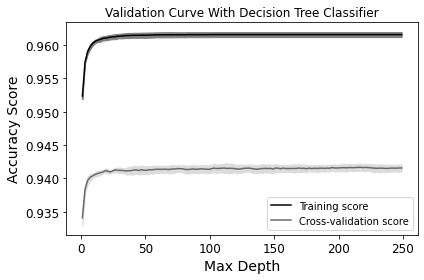

In [84]:
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

plt.title("Validation Curve With Decision Tree Classifier")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
save_fig("decision_tree_validation_curve")
plt.show()

## Further Exploration: Random Forest Classifier

In [91]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(train_data_prepared, train_labels)

final_pred = rfc.predict(test_data_prepared)

print("Precision score: ", (precision_score(test_labels, final_pred)))
print("Recall score: ", (recall_score(test_labels, final_pred)))
print("Accuracy score: ", (accuracy_score(test_labels, final_pred)))

Precision score:  0.9500764405081976
Recall score:  0.9715887648929862
Accuracy score:  0.9279763504434292


In [72]:
param_range = np.arange(1, 250, 2)

train_scores, valid_scores = validation_curve(rfc, train_data_prepared, train_labels, param_name="n_estimators", param_range=param_range,cv=3, scoring="accuracy", n_jobs=-1)

In [73]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(valid_scores, axis=1)
test_std = np.std(valid_scores, axis=1)

Saving figure random_forest_validation_curve


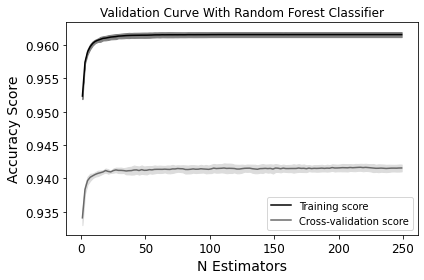

In [102]:
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

plt.title("Validation Curve With Random Forest Classifier")
plt.xlabel("N Estimators")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
save_fig("random_forest_validation_curve")
plt.show()

After looking at the models, the Random Forest Classifier performed better in terms of precision and recall scores. So I'm going to stick with the Random Forest Classifier Model and finetune it.

## Fine-Tuning Random Forest Classifier

In [88]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

In [92]:
confusion_matrix(test_labels, final_pred)

array([[ 1939,  1894],
       [ 1054, 36044]], dtype=int64)

Not a great confusion matrix, but at least there are more true positives and true negatives than false positives and false negatives.

In [93]:
print(classification_report(test_labels, final_pred))

              precision    recall  f1-score   support

           0       0.65      0.51      0.57      3833
           1       0.95      0.97      0.96     37098

    accuracy                           0.93     40931
   macro avg       0.80      0.74      0.76     40931
weighted avg       0.92      0.93      0.92     40931



In [94]:
df.patient_type.value_counts()

1    185583
0     19068
Name: patient_type, dtype: int64

This classification report makes sense. I have way more patients that were not hospitalized (185583) than patients that were hospitalized (19068), so this unbalanced dataset is going to lead to accuracy issues.

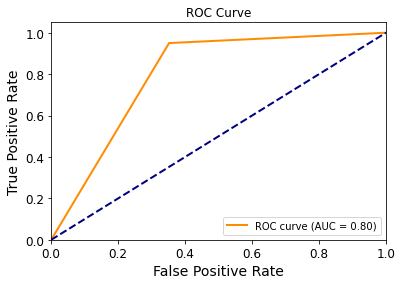

In [95]:
from sklearn.metrics import roc_curve, auc


fpr, tpr, thresholds = roc_curve(final_pred, test_labels)
roc_auc = auc(fpr, tpr)


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [96]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [97]:
scores = cross_val_score(rfc, train_data_prepared, train_labels,
                         scoring="accuracy", cv=10)
display_scores(scores)

Scores: [0.94295138 0.9438065  0.94344002 0.94386758 0.94014171 0.94026387
 0.94398974 0.94124114 0.94331786 0.94148546]
Mean: 0.9424505252870755
Standard deviation: 0.001438895004322168


In [115]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [5, 10, 100], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [5, 100], 'max_features': [2, 3, 4]},
  ]

grid_search = GridSearchCV(rfc, param_grid, cv=3,
                           scoring='accuracy',
                           return_train_score=True)
grid_search.fit(train_data_prepared, train_labels)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [5, 10, 100]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [5, 100]}],
             return_train_score=True, scoring='accuracy')

In [116]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 100}

In [117]:
grid_search.best_estimator_

RandomForestClassifier(max_features=2, random_state=42)

In [118]:
final_model = grid_search.best_estimator_

final_test_prepared = num_pipeline.fit_transform(test_data)
final_predictions = final_model.predict(final_test_prepared)

final_score = accuracy_score(test_labels, final_predictions)
final_score

0.9252400381129218